<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> IFTA en campo cercano: espacio de fases </font>
</div>

- **Para**: IFTA

- **Fecha**: 2021/11/12
        
- **Autores**: 
    - Luis Miguel Sánchez Brea
   

- **Objetivos**: Desarrollar el algoritmo IFTA en campo lejano y cercano con la binarización incorporada y eliminando la parte de amplitud / fase. 

- **Descripción** Vamos a ver cómo se comporta el espacio de fases del DOE a medida que progresa el algoritmo

- **Referencias**: 
    -R. W. Gerchberg and W. O. Saxton, “A Practical Algorithm for the Determination of Phase from Image and Diffraction Plane Pictures,” Optik (Stuttg)., vol. 35, no. 2, pp. 237–246, 1972. 

# Código

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

from py_aocg.ifta.parameters import mean_square_error, mnse, compute_error, verify_mask, make_binary

number of processors: 8
total memory        : 7.5 Gb
available memory    : 23 %
max frequency       : 4000 GHz
py_aocg
number of processors: 8
total memory        : 7.5 Gb
available memory    : 23 %
max frequency       : 4000 GHz


## Función desarrollada

In [3]:
config_phase_space = {'delta_i': 10,
                      'x_reducing_factor': 10,
                      'has_draw': True
                     }



In [4]:
def __get_phase_space(DOE_u, i, delta_i,  x_reducing_factor, has_draw):
    """ Dibuja el espacio de las fases para distintos pasos del algortimo
    
    Arguments:
        DOE_u (np.array): field with the DOE
        i (int): number of iteration
        delta_i (int): increment of iterations to add
        x_reducing_factor (int): number of daata for the phase space
    """
    
    phase = np.angle(DOE_u)
    amplitude = np.abs(DOE_u)
    amplitude = amplitude/amplitude.max()

    phase=phase.flatten()
    amplitude = amplitude.flatten()

    phase = phase[::x_reducing_factor]
    amplitude = amplitude[::x_reducing_factor]

    if (i/delta_i) ==int(i/delta_i):

        if has_draw:
            plt.figure()
            plt.polar(phase, amplitude,'k.', ms=2)
            
            """
            E_real = np.real(DOEu)
            E_imag = np.imag(DOEu)
            E_real = E_real.flatten()
            E_imag = E_imag.flatten()
            plt.figure()
            plt.plot(E_real, E_imag, 'k.', ms=1)
            plt.suptitle('nube de puntos')
            plt.xlabel('$E_{real}$')
            plt.ylabel('$E_{imag}$')
            """
            
        return phase, amplitude
    else:
        return None, None


        

In [5]:
def GS_scalar_far(source,
                  target,
                  kind,
                  is_binary,
                  num_steps,
                  phase=np.pi,
                  has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        kind (str): 'phase' or 'amplitude'
        is_binary (bool): False or True
        num_steps (int): number of steps in the algorithm
        phase (float): phase for binary masks
        has_draw (bool): If True, draws the errors.

    Returns:
        DOE (Scalar_mask_XY): DOE which produces the algoritm
        mask_final (Scalar_mask_XY): mask of algorithm (for fabrication: 0-1).
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    num_x = len(x)
    num_y = len(y)
    wavelength = target.wavelength

    if source is None:
        source = 1.

    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs * \
        np.exp(1j * 2 * phase * np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        DOEu = far_field.ifft(shift=False, matrix=True, new_field=False)
        
        DOEu = DOEu/DOEu.max()
        
        phase_map, amplitude_map =__get_phase_space(DOEu, i, **config_phase_space)

        # phase_map, amplitude_map =__get_phase_space(DOEu, i, 10, 10, has_draw=True)

        if kind == 'amplitude':
            mask = np.abs(DOEu)
            mask = mask / mask.max()
            if is_binary:
                mask = make_binary(mask, 0, 1, 0.33)
            DOEu = mask

        elif kind == 'phase':
            mask = np.angle(DOEu)
            if is_binary:
                mask = make_binary(mask, -phase / 2, phase / 2, 0)

            DOEu = np.exp(1j * mask)

        DOE.u = DOEu
        field_z = DOE.fft(shift=False, matrix=True)
        field_z = field_z / field_z.max()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))

        I_z = np.abs(field_z)**2
        I_z = I_z / I_z.mean()

        error = mean_square_error(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    mask = np.fft.fftshift(mask)
    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    return DOE, mask_final, errors

In [6]:
def GS_scalar_Fresnel(z,
                      source,
                      target,
                      kind,
                      is_binary,
                      num_steps,
                      phase=np.pi,
                      has_draw=False):
    """Gerbech-Saxton algorithm for the near field.
    Arguments:
        z (float): distance of propagation
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        kind (str): 'phase' or 'amplitude'
        is_binary (bool): False or True
        num_steps (int): number of steps in the algorithm
        phase (float): phase for binary masks
        has_draw (bool): If True, draws the errors.

    Returns:
        DOE (Scalar_mask_XY): DOE which produces the algoritm
        mask_final (Scalar_mask_XY): mask of algorithm (for fabrication: 0-1).
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    wavelength = target.wavelength
    num_x = len(x)
    num_y = len(y)

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    field_z = Scalar_mask_XY(x, y, wavelength)

    u_target = np.abs(target.u)
    I_result = np.abs(target.u)**2
    I_result_mean = I_result.mean()

    field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))

    for i in range(num_steps):
        DOE = field_z.RS(z=-z, new_field=True)
        DOEu = DOE.u

        # phase, amplitude =__get_phase_space(DOEu, i, 10,10, has_draw=True)
        phase, amplitude =__get_phase_space(DOEu, i, **config_phase_space)

        
        if kind == 'amplitude':
            mask = np.abs(DOEu)
            if is_binary:
                mask = make_binary(mask, 0, 1, 0.33)
            DOE.u = mask

        elif kind == 'phase':
            mask = np.angle(DOEu)
            if is_binary:
                mask = make_binary(mask, -np.pi / 2, np.pi / 2, 0)

            DOE.u = np.exp(1j * mask)

        field_z = (source * DOE).RS(z=z, new_field=True)
        I_z = np.abs(field_z.u)**2
        I_z = I_z * I_result_mean / I_z.mean()

        field_z.u = u_target * np.exp(1j * np.angle(field_z.u))

        error = mean_square_error(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)
        mask = mask * target.u

    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return DOE, mask_final, errors

## Mask

In [7]:
num_x=128
num_y=128
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [8]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()



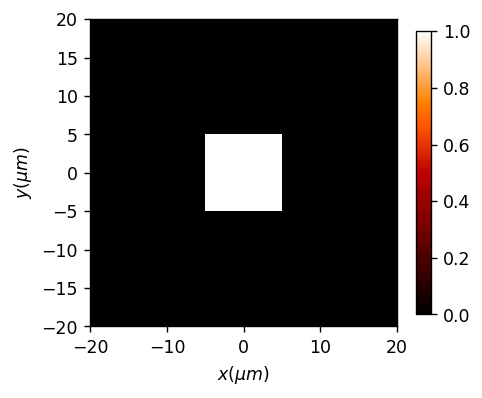

In [9]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(0,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

## Campo cercano

In [10]:
z_distance=10*um

### Amplitude continua

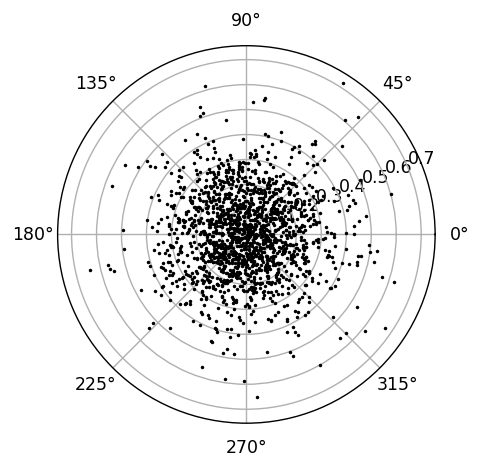

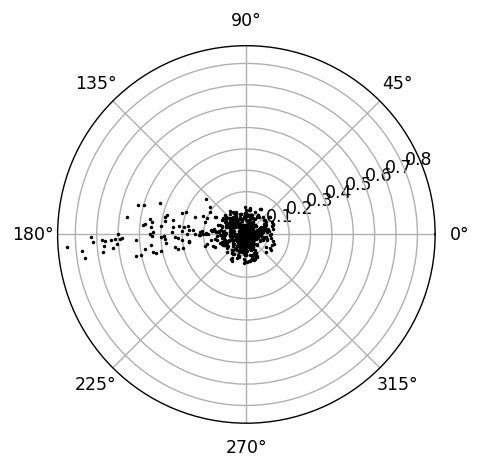

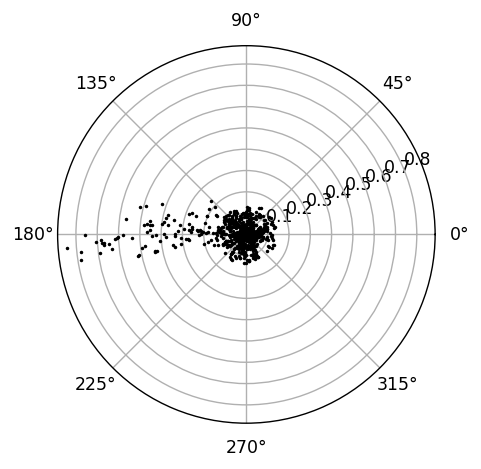

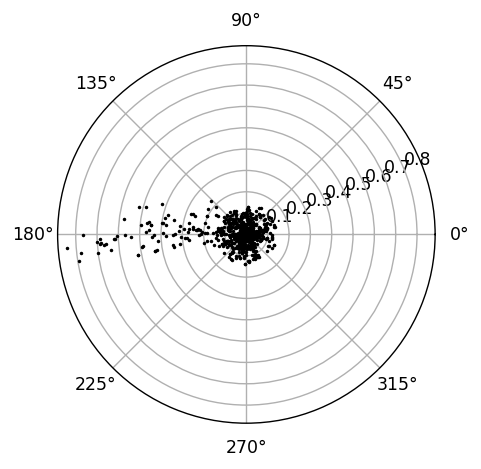

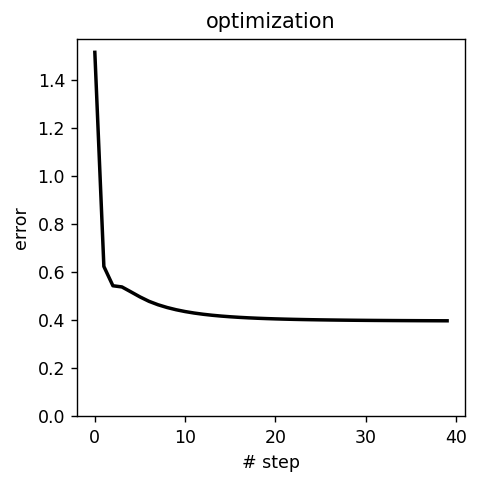

In [11]:
num_steps=40

DOE_new, mask_final, errors = GS_scalar_Fresnel(z_distance, None,target, num_steps=num_steps, kind='amplitude', is_binary=False, has_draw=True)

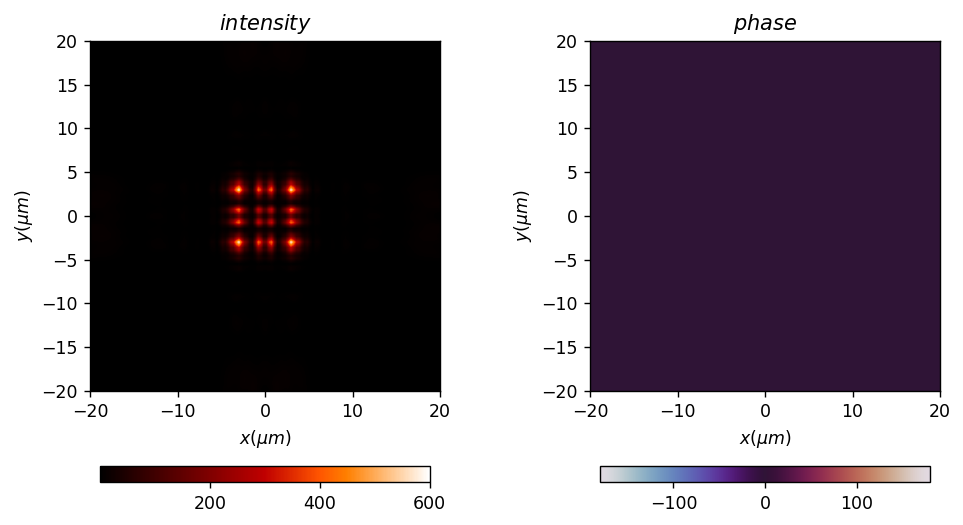

In [12]:
DOE_new.draw('field');

Good result: factor 1.50


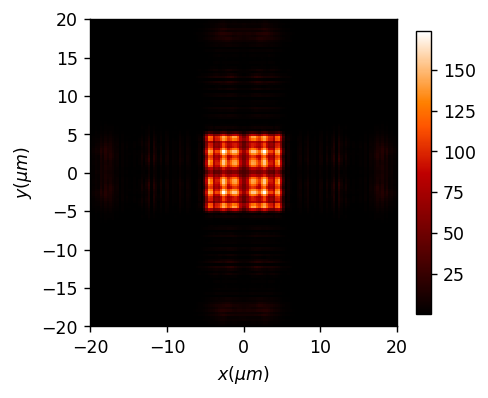

In [13]:
u_final_new = DOE_new.RS(z=z_distance, verbose=True)
u_final_new.draw(has_colorbar='vertical');

### Amplitud binaria

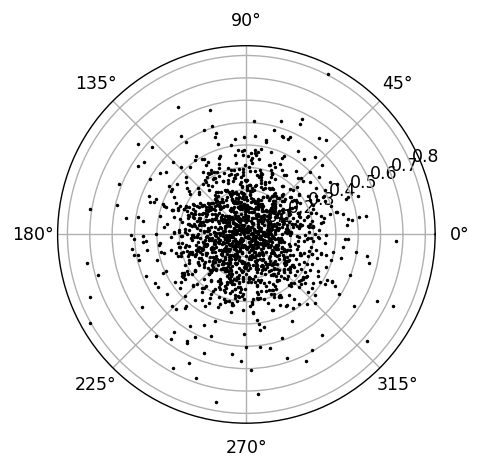

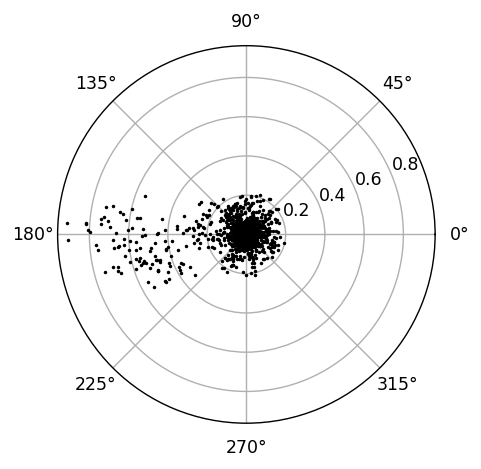

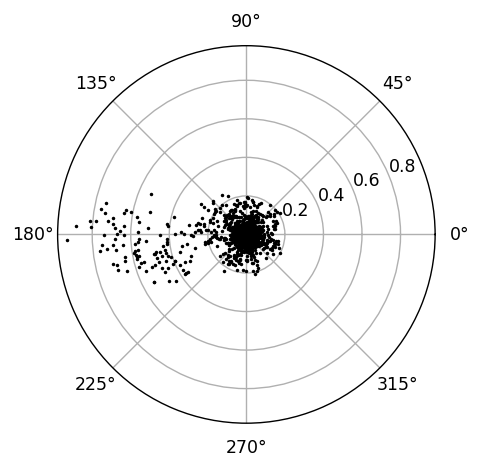

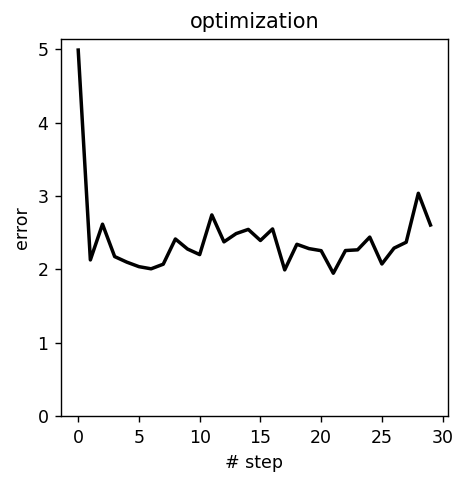

In [14]:
num_steps=30

DOE_new, mask_final, errors = GS_scalar_Fresnel(z_distance, None,target, num_steps=num_steps, kind='amplitude', is_binary=True, has_draw=True)

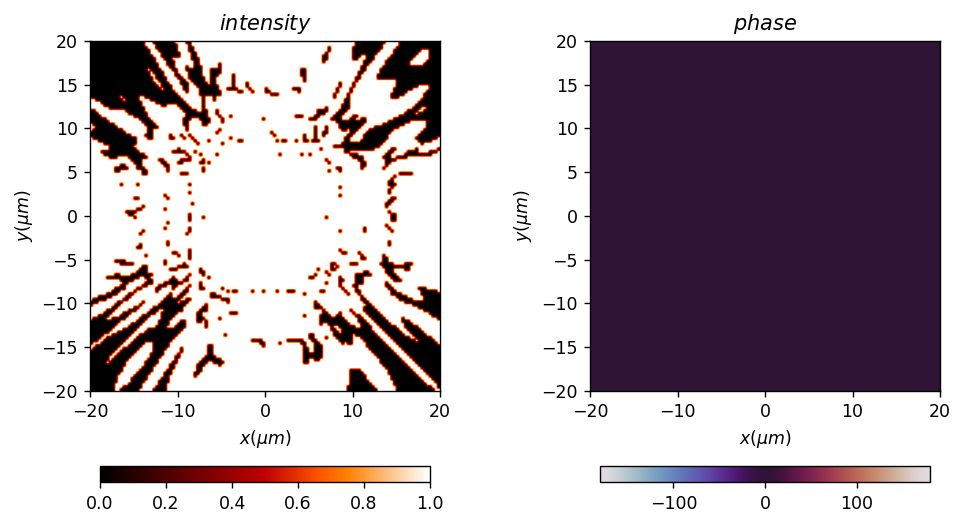

In [15]:
DOE_new.draw('field');

Good result: factor 1.50


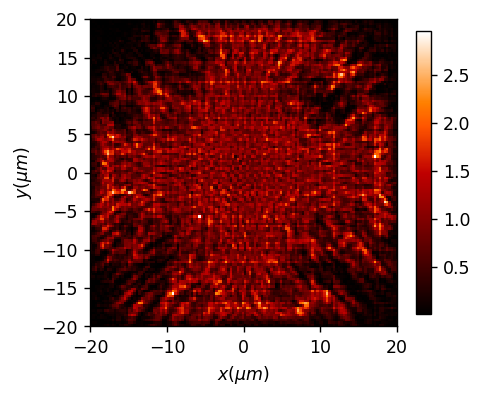

In [16]:
u_final_new = DOE_new.RS(z=z_distance, verbose=True)
u_final_new.draw(has_colorbar='vertical');

### Fase continua

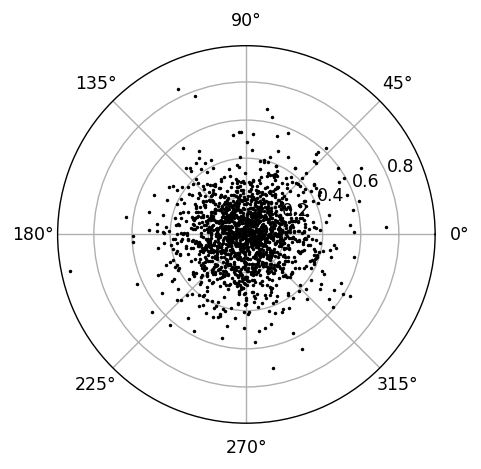

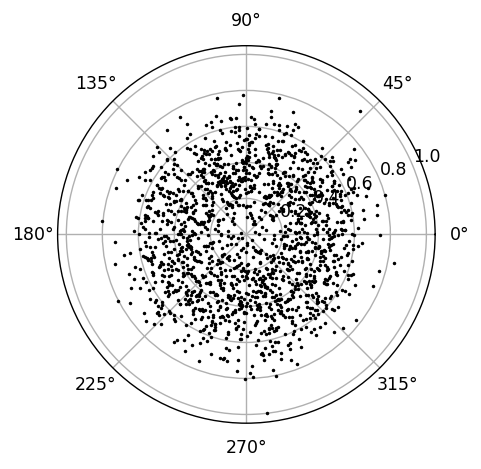

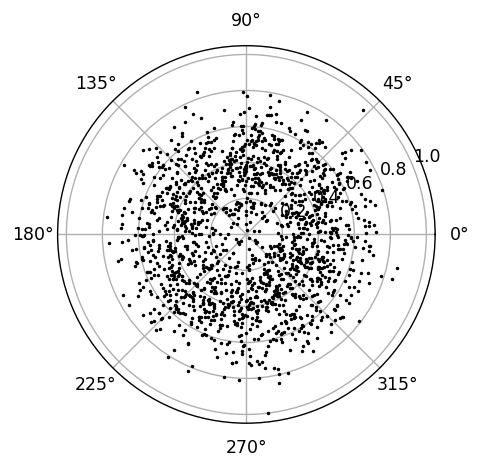

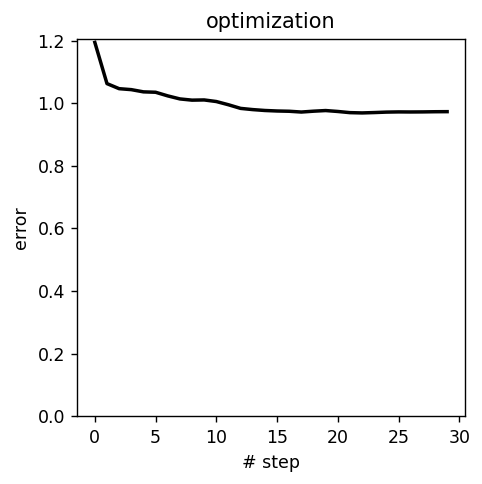

In [17]:
num_steps=30

DOE_new, mask_final, errors = GS_scalar_Fresnel(z_distance, None,target, num_steps=num_steps, kind='phase', is_binary=False, has_draw=True)

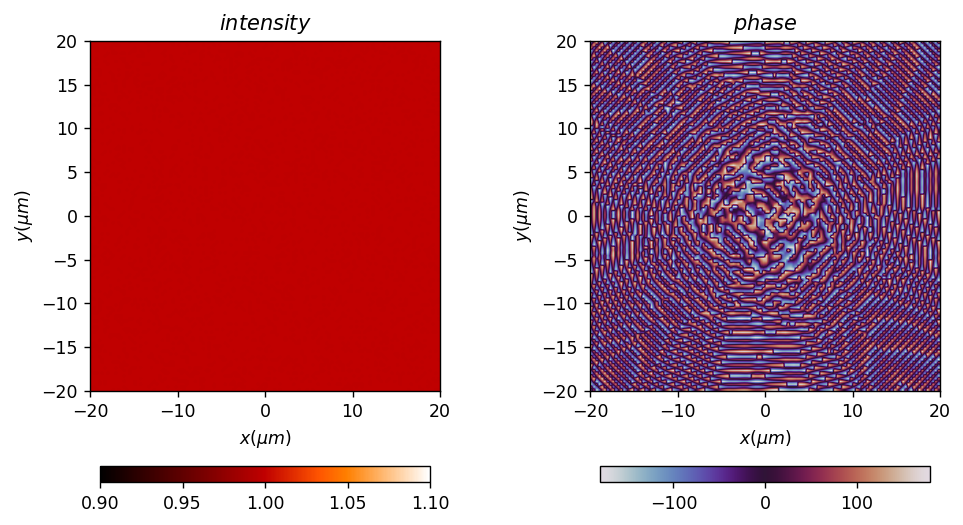

In [18]:
DOE_new.draw('field');

Good result: factor 1.50


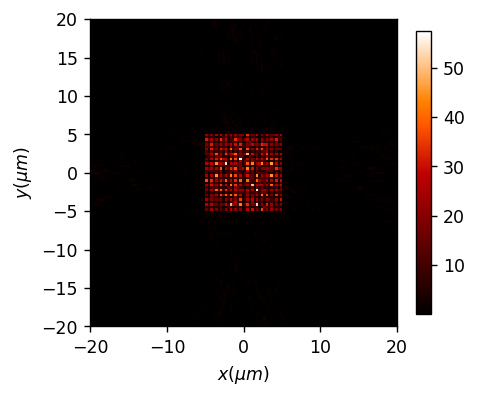

In [19]:
u_final_new = DOE_new.RS(z=z_distance, verbose=True)
u_final_new.draw(has_colorbar='vertical');

### Fase binaria

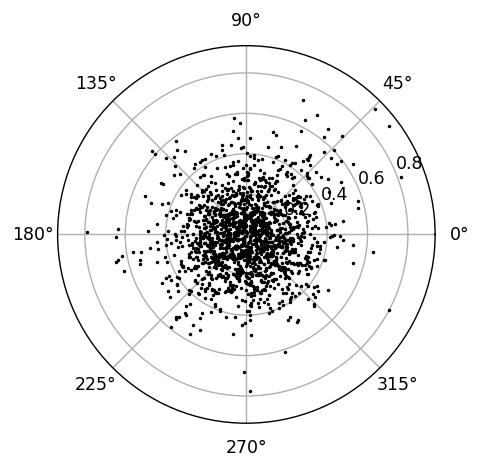

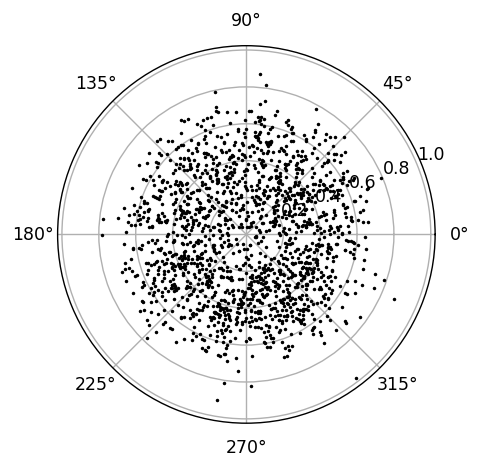

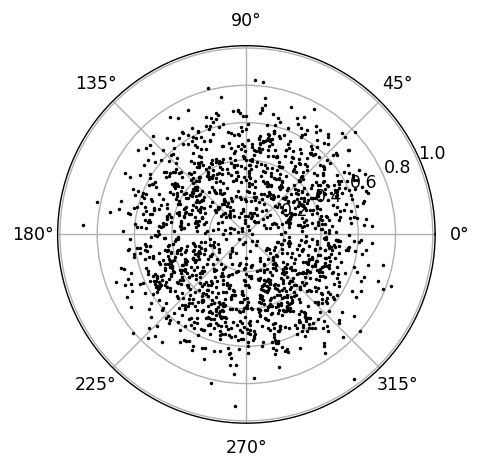

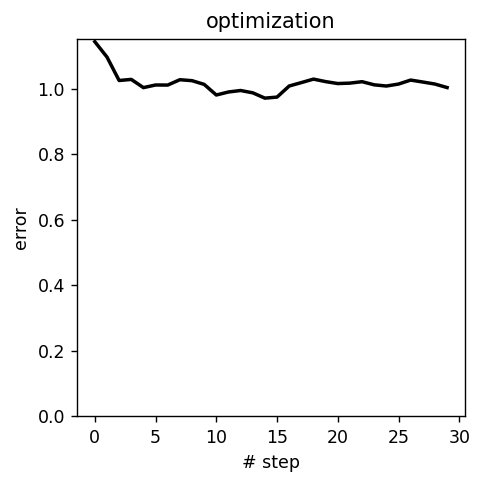

In [20]:
num_steps=30

DOE_new, mask_final, errors = GS_scalar_Fresnel(z_distance, None,target, num_steps=num_steps, kind='phase', is_binary=True, has_draw=True)

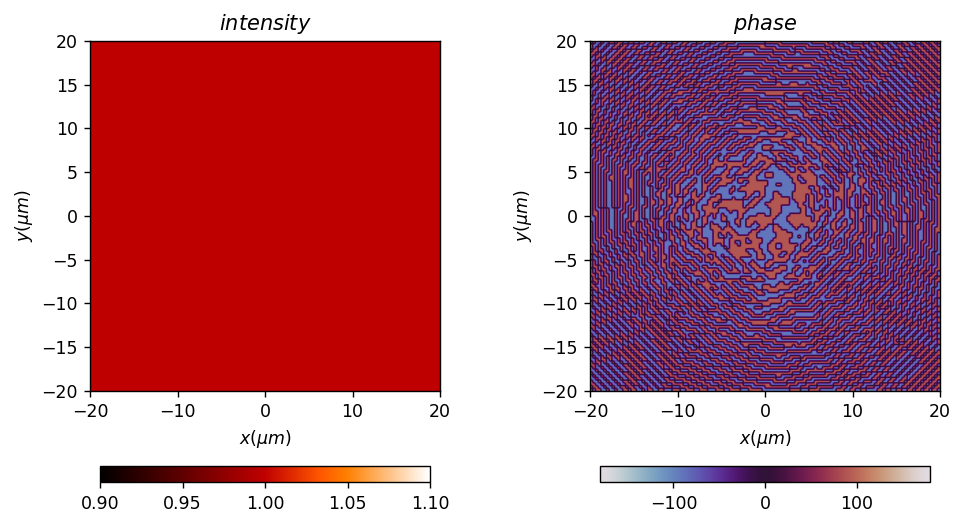

In [21]:
DOE_new.draw('field');

Good result: factor 1.50


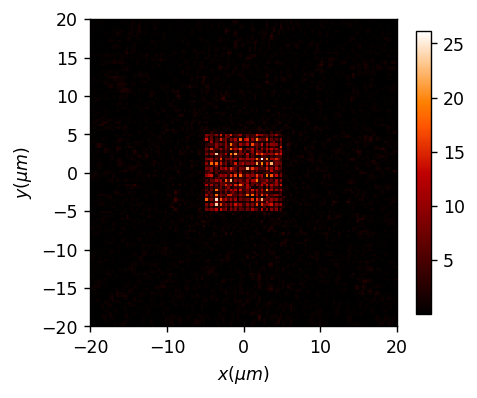

In [22]:
u_final_new = DOE_new.RS(z=z_distance, verbose=True)
u_final_new.draw(has_colorbar='vertical');

## Campo lejano

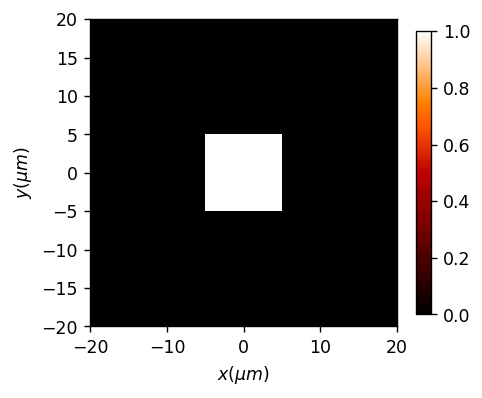

In [23]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(0,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

### phase continua

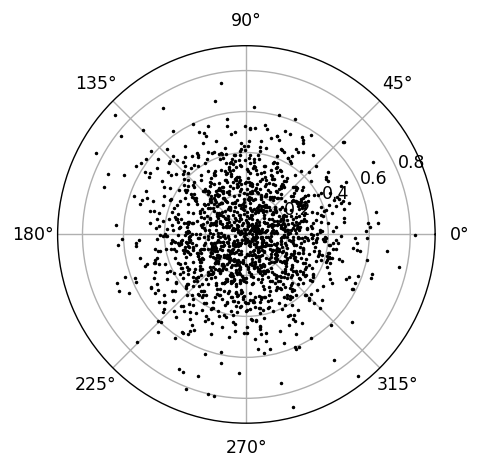

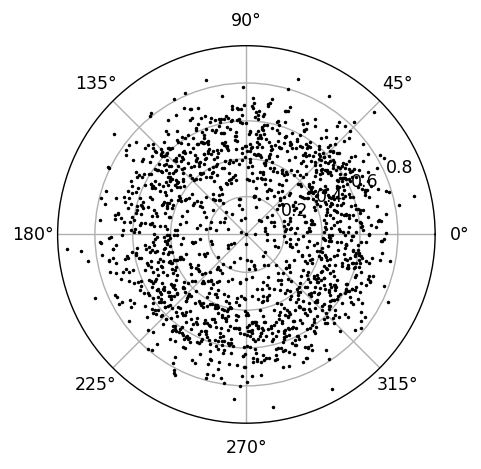

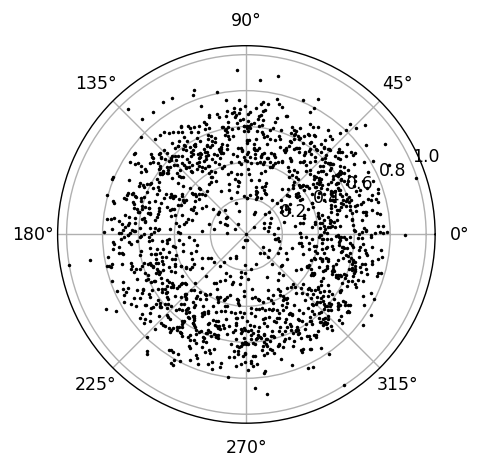

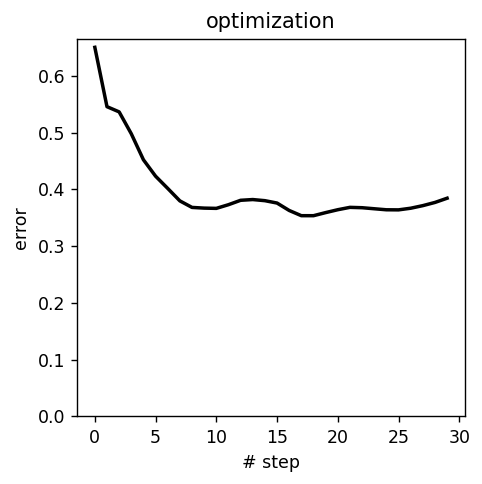

In [24]:
num_steps=30

DOE_far_old, mask_final, errors = GS_scalar_far(None,target, kind='phase', is_binary=False,  num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f20b4747ee0>)

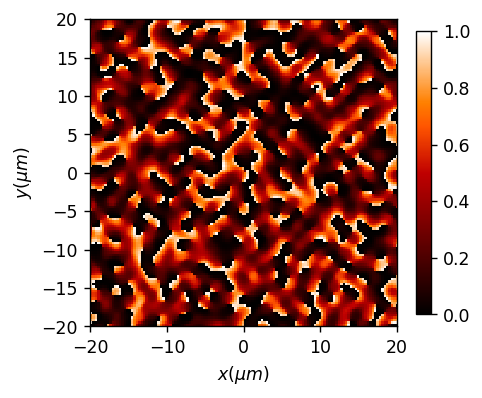

In [25]:
mask_final.draw(has_colorbar='vertical')

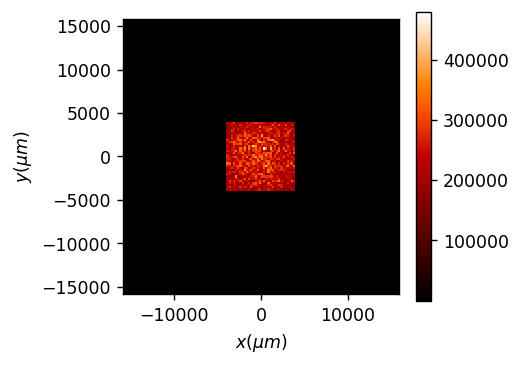

In [26]:
u_far_old = DOE_far_old.fft(new_field=True, shift=True, remove0=False)
u_far_old.draw(has_colorbar='vertical');

### Fase binaria binarizado

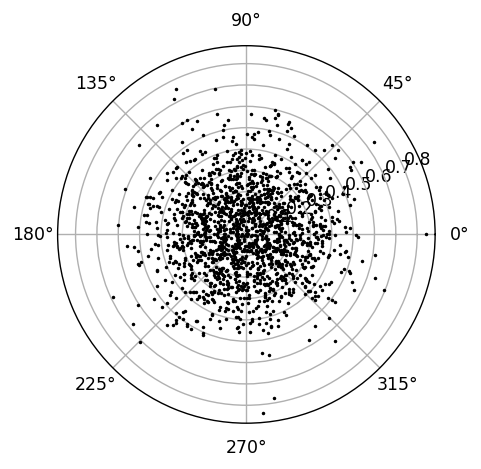

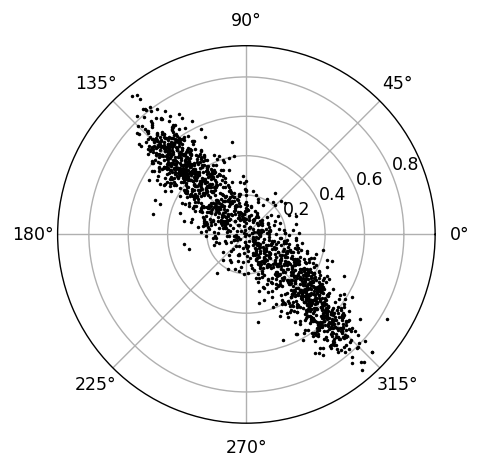

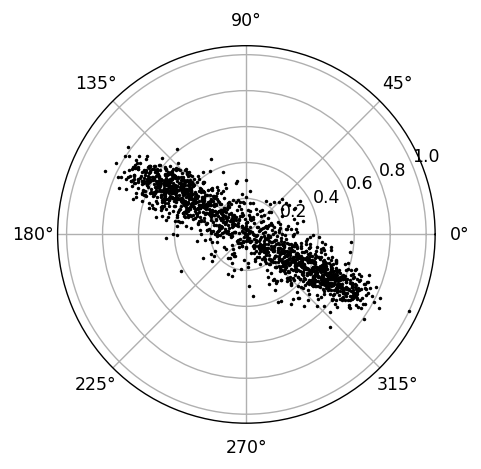

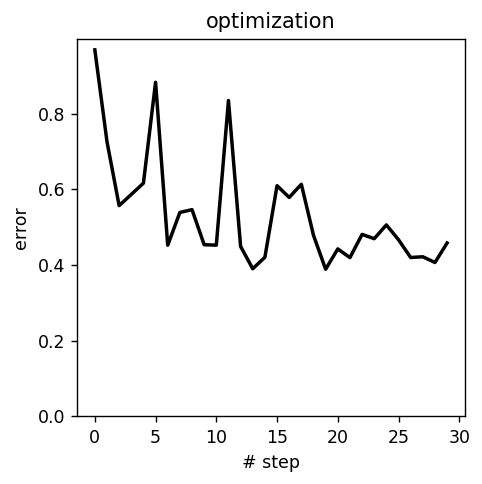

In [27]:
num_steps=30

DOE_far_new, mask_final, errors = GS_scalar_far(None,target, kind='phase', is_binary=True,  num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f20b2936ca0>)

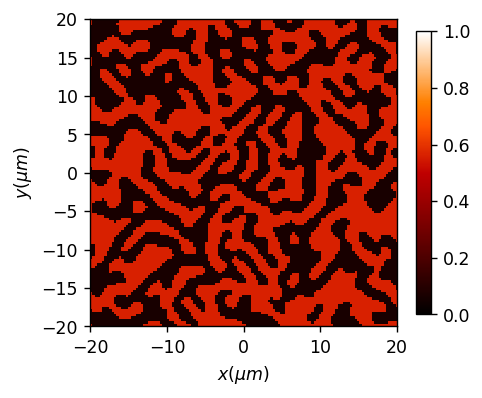

In [28]:
mask_final.draw(has_colorbar='vertical')

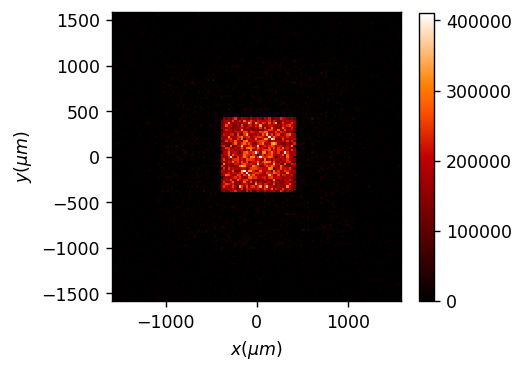

In [29]:
u_far_new = DOE_far_new.fft(z=1*mm,new_field=True, remove0=True)
u_far_new.draw(has_colorbar='vertical', logarithm=False );

### amplitud continua

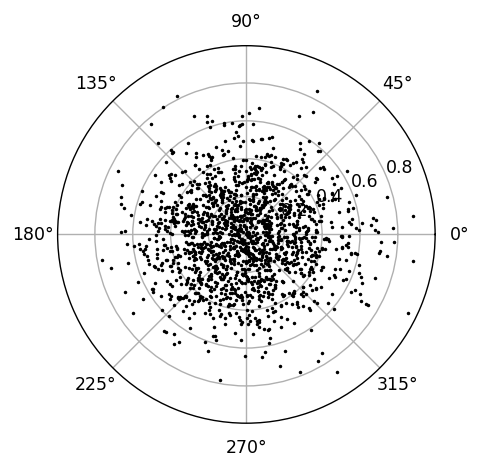

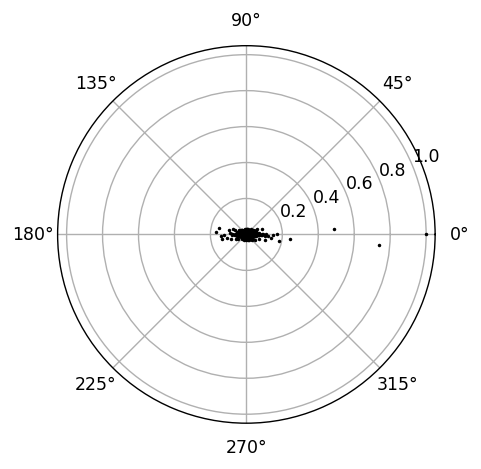

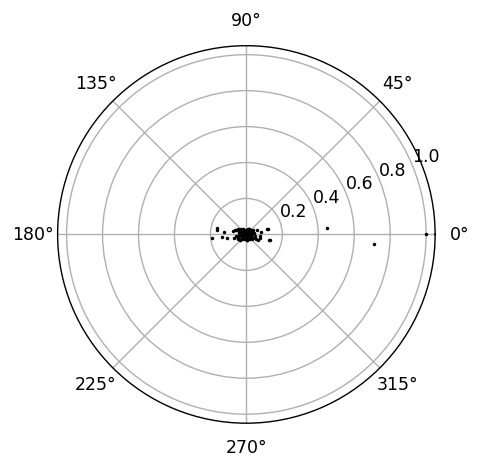

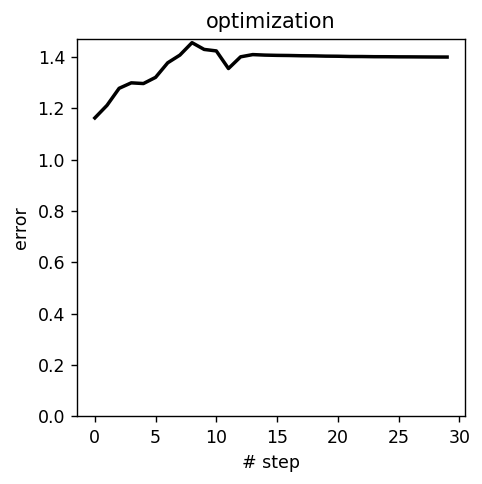

In [30]:
num_steps=30

DOE_far_old, mask_final, errors = GS_scalar_far(None,target, kind='amplitude', is_binary=False,  num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f20b2b90d30>)

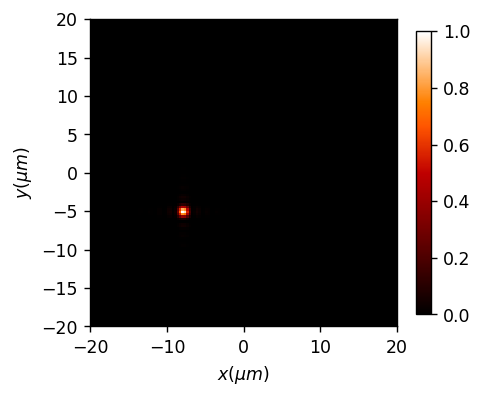

In [31]:
mask_final.draw(has_colorbar='vertical')

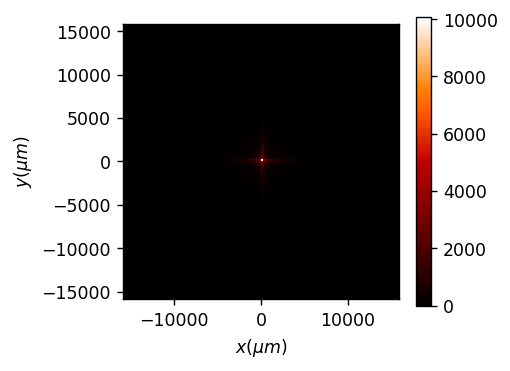

In [32]:
u_far_old = DOE_far_old.fft(new_field=True, shift=True, remove0=False)
u_far_old.draw(has_colorbar='vertical');

### amplitud binarizado

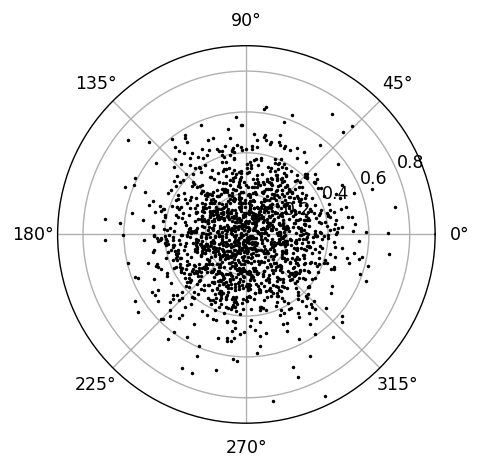

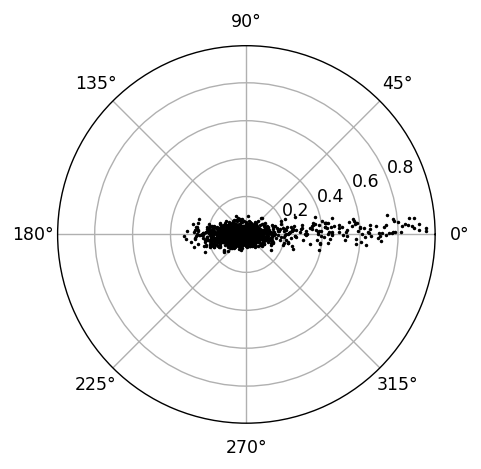

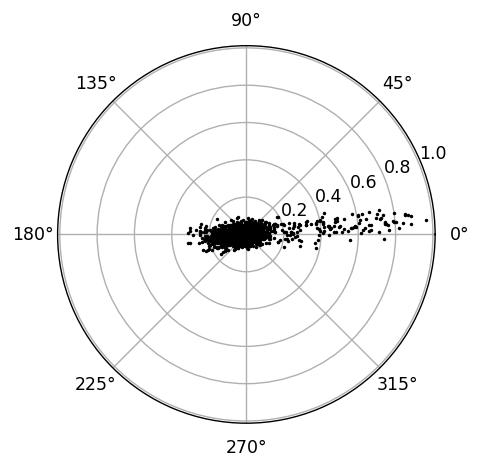

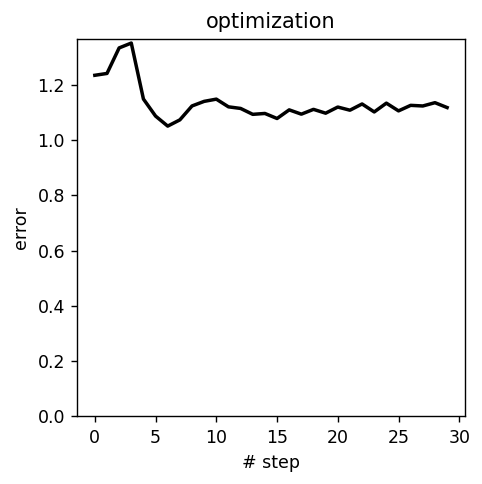

In [33]:
## Observación. En este caso no vale la división 0-0.5-1, sino que para binarizar está mejor 0-0.25-1
## Creo que sigue ganando coger la máscara binarizada de la de fáse continua y pasarla a real.

num_steps=30

DOE_far_new, mask_final, errors = GS_scalar_far(None,target, kind='amplitude', is_binary=True,  num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f20b2b3b7f0>)

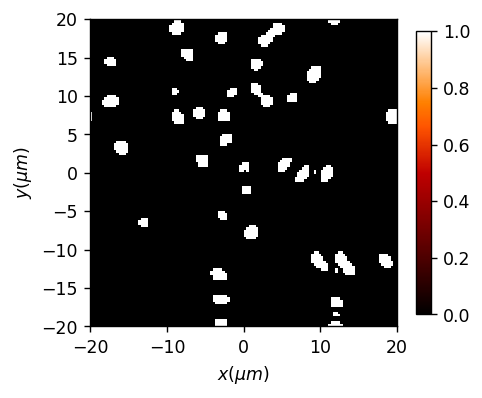

In [34]:
mask_final.draw(has_colorbar='vertical')

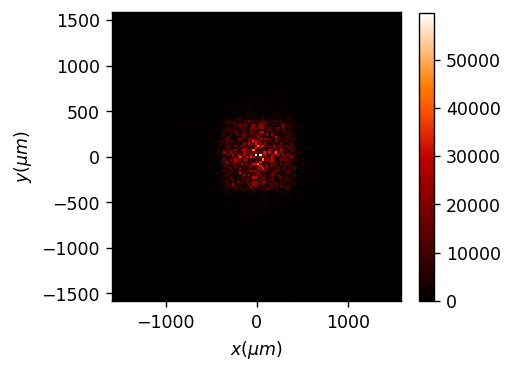

In [35]:
u_far_new = DOE_far_new.fft(z=1*mm,new_field=True, remove0=True)
u_far_new.draw(has_colorbar='vertical', logarithm=False );